In [1]:

from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:

data_df = pd.read_csv('german_processed.csv').reset_index(drop=True)
y = data_df['GoodCustomer']
X = (data_df.drop('GoodCustomer', axis=1)
     .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1))


In [3]:

## set up actionset
gender_weight = data_df.assign(c = 1).groupby('Gender')['c'].transform(lambda s: s * 1. / len(s))
X_gender_balanced = X.sample(n = len(X)*3, replace=True, weights=gender_weight)
action_set = ActionSet(X = X_gender_balanced)
action_set['Age'].mutable = False
action_set['Single'].mutable = False
action_set['JobClassIsSkilled'].mutable = False
action_set['ForeignWorker'].mutable = False
action_set['OwnsHouse'].mutable = False
action_set['RentsHouse'].mutable = False
action_set['CriticalAccountOrLoansElsewhere'].step_direction = -1
action_set['CheckingAccountBalance_geq_0'].step_direction = 1
# action_set['isMale'].mutable = False


In [4]:

# ### Train and generate AUCs
## kfold cross-val
print("...training model over indices")
manual_grid_search = False
if manual_grid_search:
    clf = LogisticRegressionCV(cv=100, max_iter=1000, solver='lbfgs')
    scores_train = []
    scores_test = []
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X.index):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        clf.fit(X_train,y_train)

        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_test, y_pred_test)
        scores_train.append(score_train)
        scores_test.append(score_test)
    print(np.mean(scores_train))
    print(np.mean(scores_test))

else:
    ## grid search
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    grid = GridSearchCV(
            clf, param_grid={'C': np.logspace(-4, 3)},
            cv=10,
            scoring='roc_auc',
            return_train_score=True
            )
    grid.fit(X, y)
    clf = grid.best_estimator_

    ## get the distribution over train and test scores across model hyperparameters
    grid_df = pd.DataFrame(grid.cv_results_)
    grid_df = (grid_df
        .assign(lambda_=lambda df: 1./df['param_C'])
        .set_index('lambda_')
    [['mean_train_score', 'mean_test_score', 'std_train_score', 'std_test_score', ]]
        )



#pickle.dump(clf, open(output_dir, '2018-08-12__demo-2-clf.pkl'), 'wb')
scores = pd.Series(clf.predict_proba(X)[:, 1])
scores.to_csv( '2018-08-12__demo-2-scores.csv')

...training model over indices


In [5]:

# cache classifier
use_cached_flipset = False
if not use_cached_flipset:
    coefficients = clf.coef_[0]
    intercept = clf.intercept_[0]
    action_set.set_alignment(coefficients=coefficients)
    # p = .8
    p = scores.median()
    denied_individuals = scores.loc[lambda s: s<=p].index

    ## run flipsets
    idx = 0
    flipsets = {}
    now = time.time()
    for i in denied_individuals:
        if idx % 50 == 0:
            print('finished %d points in %f...' %  (idx, time.time() - now))
            now = time.time()

        x = X.values[i]
        # p = scores.median()
        fb = RecourseBuilder(
                coefficients=coefficients,
                intercept = intercept - (np.log(p / (1. - p))),
                action_set = action_set,
                x = x
                )
        ## CPLEX
        cplex_output = fb.fit()
        flipsets[i] = cplex_output
        idx += 1

    flipset_df = pd.DataFrame.from_dict(flipsets, orient="index")
    flipset_df.to_csv(output_dir /  "2018-11-11_flipset-german-demo-cache.csv")

else:
    ## Examine histogram of actions
    def convert_array_col_cache_to_col(col):
        return (col.str.replace('[','')
                .str.replace(']','')
                .str.split()
                .apply(lambda x: map(float, x))
                )

    flipset_df = pd.read_csv(output_dir /  "2018-11-11_flipset-german-demo-cache.csv")
    flipset_df = (flipset_df
                  .assign(actions=lambda df: df['actions'].pipe(convert_array_col_cache_to_col))
                  .assign(costs=lambda df: df['costs'].pipe(convert_array_col_cache_to_col))
                  )
    scores = pd.read_csv(output_dir /   '2018-08-12__demo-2-scores.csv', index_col=0, squeeze=True)

flipset_df['sum_cost'] = flipset_df['costs'].apply(sum)
print(flipset_df.columns.tolist())

matching_df = pd.concat([
    data_df[['GoodCustomer', 'Gender']],
    flipset_df[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()


finished 0 points in 0.000000...
finished 50 points in 0.699582...
finished 100 points in 0.580691...
finished 150 points in 0.631582...
finished 200 points in 0.575680...
finished 250 points in 0.513326...
finished 300 points in 0.580673...
finished 350 points in 0.571735...
finished 400 points in 0.570791...
finished 450 points in 0.566423...
['cost', 'feasible', 'status', 'costs', 'actions', 'upperbound', 'lowerbound', 'gap', 'iterations', 'nodes_processed', 'nodes_remaining', 'runtime', 'sum_cost']


In [6]:



coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
action_set.set_alignment(coefficients=coefficients)
# p = .8
p = scores.median()
denied_individuals = scores.loc[lambda s: s<=p].index

## run flipsets
idx = 0
flipsets = {}
now = time.time()
for i in denied_individuals:
    if idx % 50 == 0:
        print('finished %d points in %f...' %  (idx, time.time() - now))
        now = time.time()

    x = X.values[i]
    # p = scores.median()
    fb = RecourseBuilder(
            coefficients=coefficients,
            intercept = intercept - (np.log(p / (1. - p))),
            action_set = action_set,
            x = x
            )
    ## CPLEX
    cplex_output = fb.fit()
    flipsets[i] = cplex_output
    idx += 1

flipset_df = pd.DataFrame.from_dict(flipsets, orient="index")

flipset_df.to_csv('denied_flipset.csv')


finished 0 points in 0.000501...
finished 50 points in 0.577539...
finished 100 points in 0.626023...
finished 150 points in 0.518772...
finished 200 points in 0.525571...
finished 250 points in 0.555622...
finished 300 points in 0.536134...
finished 350 points in 0.530841...
finished 400 points in 0.521976...
finished 450 points in 0.502482...


matching 2: control for y=+/- 1...


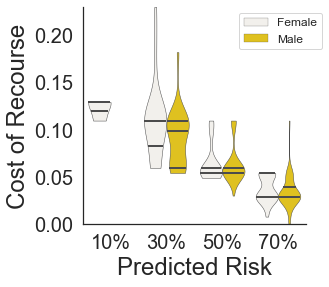

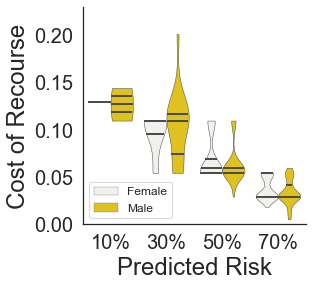

In [7]:


####### Matching 2: Control for Y=+/- 1
print("matching 2: control for y=+/- 1...")
matching_df['y_pred_bin'] = pd.cut(
        matching_df['y_pred'],
        bins=np.arange(0, .9, .2)
        )

bins = matching_df['y_pred_bin'].unique()
# (matching_df
#     .loc[lambda df: df['GoodCustomer'] == 1]
#     .loc[lambda df: df['y_pred_bin'] == bins[0]]
# )

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [-1, 1]:
    plt.figure(figsize=(4, 4))
    ax = sns.violinplot(x='y_pred_bin',  y='cost', hue='Gender',
                        data=matching_df.loc[lambda df: df['GoodCustomer'] == y_true].sort_values('Gender'),
                        linewidth = 0.5, cut=0, background='white',
                        scale = 'width', color="gold",  inner = 'quartile')
    # , inner = 'quartile', color = "gold", scale = 'width'
    ax.set_xticklabels(["10%", "30%", "50%", "70%"])#, rotation='vertical')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    # plt.title('Total Cost By Gender')
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

    # plt.legend(bbox_to_anchor=(0.1, .03, .65, .14), ncol=2, mode="expand", borderaxespad=0.)
    # plt.legend(fontsize=14, ncol=2, mode='expand',bbox_to_anchor=(.18, .51, .875, .51), )
    if y_true == -1:
        plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
    else:
        plt.legend(fontsize=12., loc='lower left')#, bbox_to_anchor=(1.1, 1))
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')
    # plt.legend(mode='expandoutput_dir + ')
    #plt.savefig(output_dir / 'matched-cost-by-y-pred-y-%d.png' % y_true, bbox_inches='tight')
    #plt.savefig(output_dir /  'matched-cost-by-y-pred-y-%d.pdf' % y_true, bbox_inches='tight')
    #plt.close()

coef_df = pd.Series(clf.coef_[0], index=X.columns).to_frame('Coefficient')
coef_df['Actionable'] = "Yes"